In [ ]:
import pandas as pd
import os
import tensorflow as tf

raw_train = tf.keras.utils.image_dataset_from_directory("Face_Age/train", labels="inferred", label_mode="categorical", 
                                          shuffle=True, batch_size=32, image_size=(224, 224))

raw_test = tf.keras.utils.image_dataset_from_directory("Face_Age/test", labels="inferred", label_mode="categorical", 
                                                       image_size=(224, 224), batch_size=32, shuffle=True)

raw_labels = pd.read_csv("Face_Age/age_detection.csv")
raw_labels['filepath'] = raw_labels["file"].apply(lambda x: os.path.join("Face_Age", x))

label_names = sorted(raw_labels['age'].unique())
label_to_index = {name: i for i, name in enumerate(label_names)}
raw_labels['label'] = raw_labels['age'].map(label_to_index)

raw_labels['one_hot'] = raw_labels['label'].apply(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(label_names)))

raw_train = raw_labels[raw_labels['split'] == 'train']
raw_test = raw_labels[raw_labels['split'] == 'test']

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), 
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=50), 
    tf.keras.layers.RandomRotation(factor=0.1, seed=50), 
    tf.keras.layers.RandomContrast(factor=0.2, seed=50), 
    tf.keras.layers.RandomBrightness(factor=0.2, seed=50), 
    tf.keras.layers.RandomZoom(0.1, seed=50)
])


def load_image(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    return image, label

def load_image_train(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    image = data_augmentation(image)
    return image, label

# tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((raw_train['filepath'].values, list(raw_train['one_hot'].values)))
train_set = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((raw_test['filepath'].values, list(raw_test['one_hot'].values)))

test_set = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Found 125 files belonging to 5 classes.


Found 25 files belonging to 5 classes.


In [ ]:
# General_model
import pandas as pd
import os
import tensorflow as tf

raw_train = tf.keras.utils.image_dataset_from_directory("Face_Age/train", labels="inferred", label_mode="categorical", 
                                          shuffle=True, batch_size=32, image_size=(224, 224))

raw_test = tf.keras.utils.image_dataset_from_directory("Face_Age/test", labels="inferred", label_mode="categorical", 
                                                       image_size=(224, 224), batch_size=32, shuffle=True)

raw_labels = pd.read_csv("Face_Age/age_detection.csv")
raw_labels['filepath'] = raw_labels["file"].apply(lambda x: os.path.join("Face_Age", x))

label_names = sorted(raw_labels['age'].unique())
label_to_index = {name: i for i, name in enumerate(label_names)}
raw_labels['label'] = raw_labels['age'].map(label_to_index)

raw_labels['one_hot'] = raw_labels['label'].apply(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(label_names)))

raw_train = raw_labels[raw_labels['split'] == 'train']
raw_test = raw_labels[raw_labels['split'] == 'test']

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), 
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=50), 
    tf.keras.layers.RandomRotation(factor=0.1, seed=50), 
    tf.keras.layers.RandomContrast(factor=0.2, seed=50), 
    tf.keras.layers.RandomBrightness(factor=0.2, seed=50), 
    tf.keras.layers.RandomZoom(0.1, seed=50)
])


def load_image(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    return image, label

def load_image_train(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    image = data_augmentation(image)
    return image, label

# tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((raw_train['filepath'].values, list(raw_train['one_hot'].values)))
train_set = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((raw_test['filepath'].values, list(raw_test['one_hot'].values)))
test_set = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

history = model.fit(
    train_set, 
    validation_data=test_set, 
    epochs=30, 
    callbacks=callbacks
)

Found 125 files belonging to 5 classes.


Found 25 files belonging to 5 classes.
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 94s 8s/step - accuracy: 0.1831 - loss: 1.7258 - val_accuracy: 0.2000 - val_loss: 1.6013 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.2639 - loss: 1.5892 - val_accuracy: 0.2000 - val_loss: 1.6028 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.3469 - loss: 1.4767 - val_accuracy: 0.1600 - val_loss: 1.6017 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.2529 - loss: 1.5606 - val_accuracy: 0.1600 - val_loss: 1.6005 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.3417 - loss: 1.4720 - val_accuracy: 0.1600 - val_loss: 1.5971 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.4448 - loss: 1.4013 - val_accuracy: 0.2000 - val_loss: 1.5947 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step -

In [80]:
model.save('face_age_detector.keras')

In [81]:
# Trying to reduce data augmentatiion
import pandas as pd
import os
import tensorflow as tf

raw_train = tf.keras.utils.image_dataset_from_directory("Face_Age/train", labels="inferred", label_mode="categorical", 
                                          shuffle=True, batch_size=32, image_size=(224, 224))

raw_test = tf.keras.utils.image_dataset_from_directory("Face_Age/test", labels="inferred", label_mode="categorical", 
                                                       image_size=(224, 224), batch_size=32, shuffle=True)

raw_labels = pd.read_csv("Face_Age/age_detection.csv")
raw_labels['filepath'] = raw_labels["file"].apply(lambda x: os.path.join("Face_Age", x))

label_names = sorted(raw_labels['age'].unique())
label_to_index = {name: i for i, name in enumerate(label_names)}
raw_labels['label'] = raw_labels['age'].map(label_to_index)

raw_labels['one_hot'] = raw_labels['label'].apply(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(label_names)))

raw_train = raw_labels[raw_labels['split'] == 'train']
raw_test = raw_labels[raw_labels['split'] == 'test']

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), 
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=50), 
    tf.keras.layers.RandomRotation(factor=0.05, seed=50), 
])


def load_image(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    return image, label

def load_image_train(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    image = data_augmentation(image)
    return image, label

# tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((raw_train['filepath'].values, list(raw_train['one_hot'].values)))
train_set = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((raw_test['filepath'].values, list(raw_test['one_hot'].values)))
test_set = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

history = model.fit(
    train_set, 
    validation_data=test_set, 
    epochs=30, 
    callbacks=callbacks
)

Found 125 files belonging to 5 classes.
Found 25 files belonging to 5 classes.
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 91s 8s/step - accuracy: 0.1694 - loss: 1.6914 - val_accuracy: 0.1600 - val_loss: 1.6645 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.1736 - loss: 1.6741 - val_accuracy: 0.2000 - val_loss: 1.6618 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.3468 - loss: 1.5513 - val_accuracy: 0.2000 - val_loss: 1.6584 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.3097 - loss: 1.5536 - val_accuracy: 0.2400 - val_loss: 1.6547 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.3726 - loss: 1.4638 - val_accuracy: 0.2000 - val_loss: 1.6519 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.6231 - loss: 1.2872 - val_accuracy: 0.2000 - val_loss: 1.6487 - learning_rate: 1.0000e-04
Epoch 7/3

In [82]:
# label_smoothing
# L2 weight decay on Dense layers
# Class weighting
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight

raw_train = tf.keras.utils.image_dataset_from_directory("Face_Age/train", labels="inferred", label_mode="categorical", 
                                          shuffle=True, batch_size=32, image_size=(224, 224))

raw_test = tf.keras.utils.image_dataset_from_directory("Face_Age/test", labels="inferred", label_mode="categorical", 
                                                       image_size=(224, 224), batch_size=32, shuffle=True)

raw_labels = pd.read_csv("Face_Age/age_detection.csv")
raw_labels['filepath'] = raw_labels["file"].apply(lambda x: os.path.join("Face_Age", x))

label_names = sorted(raw_labels['age'].unique())
label_to_index = {name: i for i, name in enumerate(label_names)}
raw_labels['label'] = raw_labels['age'].map(label_to_index)

raw_labels['one_hot'] = raw_labels['label'].apply(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(label_names)))

raw_train = raw_labels[raw_labels['split'] == 'train']
raw_test = raw_labels[raw_labels['split'] == 'test']

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), 
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=50), 
    tf.keras.layers.RandomRotation(factor=0.1, seed=50), 
    tf.keras.layers.RandomContrast(factor=0.2, seed=50), 
    tf.keras.layers.RandomBrightness(factor=0.2, seed=50), 
    tf.keras.layers.RandomZoom(0.1, seed=50)
])


def load_image(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    return image, label

def load_image_train(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    image = data_augmentation(image)
    return image, label

# tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((raw_train['filepath'].values, list(raw_train['one_hot'].values)))
train_set = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((raw_test['filepath'].values, list(raw_test['one_hot'].values)))
test_set = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) # Adding regularizers
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Label smoothing
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(raw_train['label']), 
    y=raw_train['label']
)
class_weights = dict(enumerate(weights))

history = model.fit(
    train_set, 
    validation_data=test_set, 
    epochs=30, 
    class_weight=class_weights, 
    callbacks=callbacks
)

Found 125 files belonging to 5 classes.
Found 25 files belonging to 5 classes.
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.2196 - loss: 1.7528 - val_accuracy: 0.2000 - val_loss: 1.6640 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.2084 - loss: 1.6968 - val_accuracy: 0.2000 - val_loss: 1.6466 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.3136 - loss: 1.6017 - val_accuracy: 0.2400 - val_loss: 1.6322 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.3700 - loss: 1.5296 - val_accuracy: 0.2400 - val_loss: 1.6219 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.4227 - loss: 1.5112 - val_accuracy: 0.2400 - val_loss: 1.6124 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.4243 - loss: 1.4695 - val_accuracy: 0.2400 - val_loss: 1.6031 - learning_rate: 1.0000e-04
Epoch 7/3

In [83]:
model.save('better_face_age_detector.keras')
model.save("better_face_age_detector.h5")

In [97]:
# label_smoothing
# L2 weight decay on Dense layers
# Class weighting
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight

raw_train = tf.keras.utils.image_dataset_from_directory("Face_Age/train", labels="inferred", label_mode="categorical", 
                                          shuffle=True, batch_size=32, image_size=(224, 224))

raw_test = tf.keras.utils.image_dataset_from_directory("Face_Age/test", labels="inferred", label_mode="categorical", 
                                                       image_size=(224, 224), batch_size=32, shuffle=True)

raw_labels = pd.read_csv("Face_Age/age_detection.csv")
raw_labels['filepath'] = raw_labels["file"].apply(lambda x: os.path.join("Face_Age", x))

label_names = sorted(raw_labels['age'].unique())
label_to_index = {name: i for i, name in enumerate(label_names)}
raw_labels['label'] = raw_labels['age'].map(label_to_index)

raw_labels['one_hot'] = raw_labels['label'].apply(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(label_names)))

raw_train = raw_labels[raw_labels['split'] == 'train']
raw_test = raw_labels[raw_labels['split'] == 'test']

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), 
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=50), 
    tf.keras.layers.RandomRotation(factor=0.1, seed=50), 
    tf.keras.layers.RandomContrast(factor=0.2, seed=50), 
    tf.keras.layers.RandomBrightness(factor=0.2, seed=50), 
    tf.keras.layers.RandomZoom(0.1, seed=50), 
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=50)
])


def load_image(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    return image, label

def load_image_train(path, label):
    """Function to load and preprocess images"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess(image) # Sequential pipeline above
    image = data_augmentation(image)
    return image, label

# tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((raw_train['filepath'].values, list(raw_train['one_hot'].values)))
train_set = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((raw_test['filepath'].values, list(raw_test['one_hot'].values)))
test_set = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) # Adding regularizers
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Label smoothing
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(raw_train['label']), 
    y=raw_train['label']
)
class_weights = dict(enumerate(weights))

history = model.fit(
    train_set, 
    validation_data=test_set, 
    epochs=30, 
    class_weight=class_weights, 
    callbacks=callbacks
)


Found 125 files belonging to 5 classes.


Found 25 files belonging to 5 classes.
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 11s/step - accuracy: 0.1745 - loss: 1.7864 - val_accuracy: 0.2400 - val_loss: 1.6853 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.2869 - loss: 1.6482 - val_accuracy: 0.2400 - val_loss: 1.6827 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.2432 - loss: 1.6299 - val_accuracy: 0.2000 - val_loss: 1.6777 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.3178 - loss: 1.5727 - val_accuracy: 0.2400 - val_loss: 1.6715 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.3660 - loss: 1.5434 - val_accuracy: 0.2400 - val_loss: 1.6656 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.3798 - loss: 1.5160 - val_accuracy: 0.3200 - val_loss: 1.6571 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step

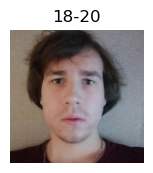

In [88]:
import matplotlib.pyplot as plt

index_to_label = {i: name for name, i in label_to_index.items()}

for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
    
        plt.imshow(images[i].numpy().astype('uint8'))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(index_to_label[label_index])
        plt.axis('off')
        break

plt.tight_layout()
plt.show()

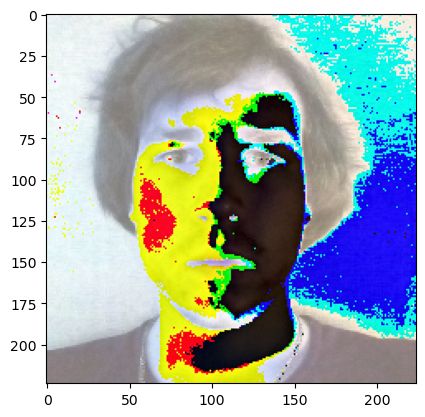

In [89]:
def viewable_image(img_tensor):
    img = img_tensor.numpy()
    img = img + [103.939, 116.779, 123.68]  # reverse ResNet50 preprocessing
    img = img[..., ::-1]  # BGR to RGB
    return img.astype("uint8")

plt.imshow(viewable_image(images[i]))